# MLP (Multi-Layer Perceptron)

## Tensor Flow
O TensorFlow é uma camada de infraestrutura para programação diferenciável. Em sua essência, é uma estrutura para manipular matrizes N-dimensionais (tensores), bem como **NumPy**.

No entanto, existem três diferenças principais entre o NumPy e o TensorFlow:

- O TensorFlow pode aproveitar aceleradores de hardware, como GPUs e TPUs.
- O TensorFlow pode calcular automaticamente o gradiente de expressões de tensor diferenciáveis ​​arbitrárias.
- A computação do TensorFlow pode ser distribuída para um grande número de dispositivos em uma única máquina e um grande número de máquinas (potencialmente com vários dispositivos cada).

## Keras
Enquanto o TensorFlow é uma camada de infraestrutura para programação diferenciável, lidando com tensores, variáveis e gradientes, **Keras é uma interface de usuário para aprendizado profundo, lidando com camadas, modelos, otimizadores, funções de perda, métricas e muito mais**.

Keras serve como a API de alto nível para TensorFlow: Keras é o que torna o TensorFlow simples e produtivo.

A classe **Layer**  é a abstração fundamental em Keras: ela encapsula um estado (pesos) e alguma computação (definida no método de chamada).

- Doc: https://keras.io/getting_started/intro_to_keras_for_researchers/

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing Tensor Flow
import tensorflow as tf

# Importing Keras API
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout

In [214]:
# Importing Fashion MNIST dataset from keras
# Este dataset vem separado em 2 tuplas: treino e teste
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [215]:
# 60mil registros de Treino, 10mil registros de Teste, sendo X com 28 linhas x 28 colunas
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [216]:
# Dividindo o conjunto de Treinamento em Train/Valid
# Valid: primeiros 5mil registros
# Train: O restante dos 55mil registros

X_valid, X_train = X_train_full[:5000], X_train_full[5000:] # Features
y_valid, y_train = y_train_full[:5000], y_train_full[5000:] # Labels

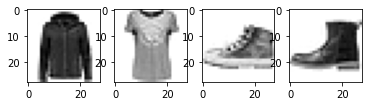

In [217]:
# Visualizando as imagens do dataset
plt.figure()
plt.subplot(1,4,1)
plt.imshow(X_train[0], cmap="binary")
plt.subplot(1,4,2)
plt.imshow(X_train[1], cmap="binary")
plt.subplot(1,4,3)
plt.imshow(X_train[2], cmap="binary")
plt.subplot(1,4,4)
plt.imshow(X_train[3], cmap="binary")
plt.show()

### Escalonando as Features

In [218]:
# Escalonando as Features (X), pois como utilizamos o SGD, precisamos standarizar os valores 
# para uma melhor e mais rápida convergência.
# Como as cores RGB variam de valores 0 a 255, ao dividirmos por 255 escalamos os valores para o intervalo 0 a 1.
# Obs: Ao fazemos isto, já convertemos os valores para 'float', o que é necessário para utilizamos o modelo depois.
X_valid = X_valid / 255.0
X_train = X_train / 255.0
X_test = X_test / 255.0

In [219]:
# Como cada classe é definida por um número, vamos criar uma lista com os nomes das classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Instanciando um modelo MLP

Hiperparâmetros Importantes:
- Arquitetura da rede
- Otimizador
- Taxa de aprendizado do Otimizador
- Decaimento/Escalonador de taxa de aprendizado
- Regularização (tipo, intensidade)

**IMPORTANTE:** Seja qual for o tipo de Camada de Entrada (Flatten, Dense, Conv2D), o parâmetro **'input_shape'** sempre deve ser passado nesta Camada!

Primeiramente, definimos como será a **Arquitetura da nossa Rede**:
- **Tipo e Quantidade de Camadas**
- **Quantidade de Neurônios por camada**
- **Funções de Ativação**
- **Kernel de Inicialização**: https://keras.io/api/layers/initializers/

*mlp.Dense(units, activation, use_bias, kernel_initializer, bias_initializer, kernel_regularizer, bias_regularizer, activity_regularizer, ...)*
- Doc: https://keras.io/api/layers/

Depois, adicionamos alguma **Regularização** para evitar Overfitting:
- **Batch Normalization**: Alguns autores defendem que esta camada deve ser inserida antes da função de ativação. No exemplo abaixo, estamos utilizando após. Para adicionarmos antes, devemos retirar a função de ativação da camada (activation='relu'), e adicioná-la depois: layers.Activation('relu'). 
- **Dropout**: Considere dropout para grandes camadas lineares.
- **Regularização**: Utilize regularização L2. kernel_regularizer='l2'

In [220]:
# 'Sequential' groups a linear stack of layers into a 'tf.keras.Model'.
mlp = Sequential([

    # CAMADA DE ENTRADA: 
    # Neste caso, usamos a camada Flatten pois temos como entrada uma Matriz 2D,
    # e assim ela já converte para um Array 1D (flatten=achatada). Caso contrário, teríamos que
    # aplicar um reshape(-1,num_features) quando formos treinar o modelo.
    
    Flatten(input_shape=[28,28]), # Seja qual for o tipo de Camada de Entrada, o parâmetro 'input_shape' sempre deve ser usado.
    BatchNormalization(), # Adicionando BatchNormalization após cada camada (inclusive a de Input)
    
    # Também podemos criar a Camada de Entrada assim: Input(shape=(784,))
    # Ou direto na primeira Camada oculta assim: Dense(units=300, activation='relu', input_shape=(784,))
    # Mas como temos um Matriz, é mais recomendado utilizar o Flatten() pois fica mais prático para trabalhar depois.

    # CAMADAS OCULTAS:
    # Geralmente usamos a ativação 'relu' nas camadas ocultas (portanto, inicialização 'He')
    Dense(units=300, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(units=100, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    # CAMADA DE SAÍDA:
    # No caso de Classificação, n_units = n_classes). 
    # Geralmente usamos a ativação 'softmax' para > 2 classes. Para binária, sigmoid. Para Regressão, nenhuma ou 'softplus'
    Dense(units=10, activation='softmax')
])

Também podemos instanciar assim, adicionando as camadas com o método add():
```python
mlp = Sequential()
mlp.add(keras.Flatten(input_shape=[28,28])
mlp.add(Dense(units=300, activation='relu'))
mlp.add(Dense(units=100, activation='relu'))
mlp.add(Dense(units=10, activation='softmax'))
```

In [221]:
# O método summary() exibe informações das camadas do modelo
mlp.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_45 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_46 (Dense)            (None, 100)               30100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)            

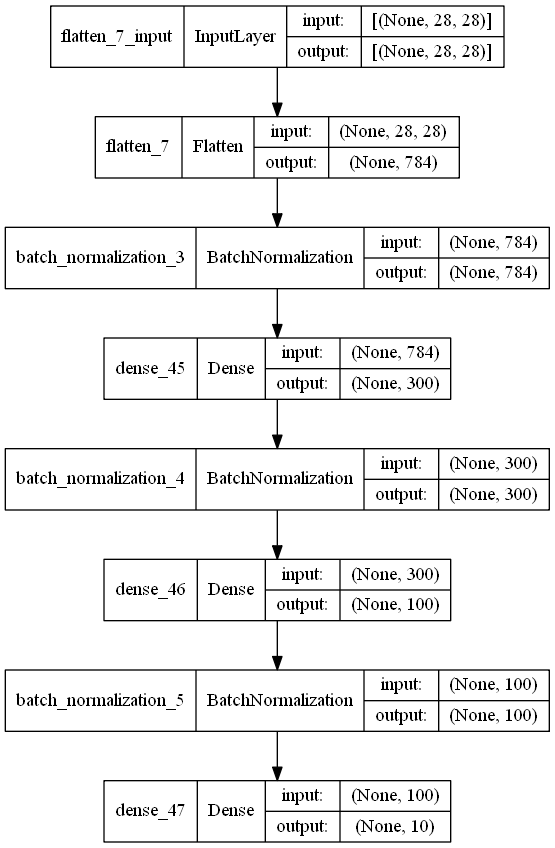

In [222]:
# Podemos também Plotar o modelo:
keras.utils.plot_model(mlp, show_shapes=True)

## Compilando o Modelo
É aqui que escolho os hiperparâmetros como:
- **Otimizador**: Adam, SGD, etc.
- **Função de Custo (Loss)**: sparse_categorical_crossentropy, binary_crossentropy, mse, etc.
- **Métricas de avaliação**: passamos este param como uma lista, pois podemos passar mais de uma métrica de avaliação. Ex: metrics=['accuracy', 'precision']

*mlp.compile(optimizer, loss, metrics)*

In [223]:
# Podemos instanciar um Otimizador para podermos ajustar seus parâmetros. 
# Ex: otimizador = keras.optimizers.Adam(learning_rate, beta_1, beta_2)
# Beta 1: momentum (“fricção”) e Beta 2: decaimento (geralmente funcionam bem assim, 
# não é necessário ajustar estes hiperparâmetros).
# Caso eu queira usar a configuração default, basta inserirmos direto no compile(optimizer='adam').

print('Formato dos labels:', np.unique(y_train))

mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Formato dos labels: [0 1 2 3 4 5 6 7 8 9]


Quando usar 'categorical_crossentropy' e 'sparse_categorical_crossentropy'?
- *categorical_crossentropy*: quando a lista de labels estiver no formato **one-hot**: [0,1,0,0,0], [0,0,0,0,1]
- *sparse_categorical_crossentropy*: quando a lista de labels estiver no formato de **números inteiros**: [1], [5]

## Treinando o Modelo
Nesta fase que definimos outros hiperparâmetros:
- **Batch**: o default é 32
- **Épocas**
- **Early Stopping**: Para o treinamento quando uma métrica especificada pára de melhorar. Definimos o param 'patience' para estipular após quantas Épocas sem melhora da métrica deve parar. Por padrão, a métrica monitorada é o 'val_loss', uma vez que estamos interessados em minimizar esta função de custo, que é baseada no conjunto de validação. Dica: Ao usarmos um critério Early Stopping, podemos definir um número alto para Épocas, uma vez que o processo provavelmente será parado antes da conclusão de todas.
- **Checking Points:**: Ao treinar um modelo, pode demorar muito tempo e pode ocorrer algum erro durante o treinamento (hardware ou software). Portanto, recomenda-se salvar alguns pontos de verificação durante o processo de treinamento. Para isto, também utilizamos o parâmetro *'callbacks'* dentro do fit(): *callbacks=[keras.callbacks.ModelCheckpoint('nome_arquivo.h5', save_best_only=True)]*.  
- **Conjunto de Avaliação**: temos 2 formas de fazer:
1) Passamos qual conjunto queremos fazer a avaliação do modelo, no caso o conjunto de Validação: *validation_data=(X_valid, y_valid)*. 
2) Ou podemos fazer de forma automática, informando apenas o param *'validation_split=0.1'*, o qual informa que queremos utilizar um percentual (neste caso 10%) do conjunto de treinamento para fazermos a validação. Desta forma, não precisamos dividir o conjunto de treinamento em train/valid, que fizemos acima.

*mlp.fit(X_train, y_train, epochs, batch_size, validation_data)*

**Importante**: Se não estivermos satisfeitos e chamarmos novamente o fit(), o Keras continua o treinamento de onde parou. 

In [224]:
# Obs: Como instanciamos a Camada de Input como Flatten(), não precisamos fazer um reshape() em X, 
# pois elas está como Array 2D (e precisaríamos passar como Array 1D). 
# O Flatten() faz a conversão de forma automática
# Ex: mlp.fit(X_train.reshape(-1,784), y_train, epochs=30, validation_data=(X_valid.reshape(-1,784), y_valid))

mlp.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), 
        callbacks=[keras.callbacks.EarlyStopping(patience=5), 
                   keras.callbacks.ModelCheckpoint('checkpoint_model.h5', save_best_only=True)])

Epoch 1/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4774 - accuracy: 0.8277 - val_loss: 0.3714 - val_accuracy: 0.8660
Epoch 2/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3660 - accuracy: 0.8653 - val_loss: 0.3336 - val_accuracy: 0.8774
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3263 - accuracy: 0.8790 - val_loss: 0.3136 - val_accuracy: 0.8842
Epoch 4/30
1719/1719 [==============================] - 9s 6ms/step - loss: 0.3021 - accuracy: 0.8874 - val_loss: 0.2981 - val_accuracy: 0.8954
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2808 - accuracy: 0.8949 - val_loss: 0.2943 - val_accuracy: 0.8946
Epoch 6/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2647 - accuracy: 0.8997 - val_loss: 0.3155 - val_accuracy: 0.8886
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2501 - accuracy: 0.9059 - val_loss: 0.3004 - val_accurac

Podemos verificar os **Pesos** e **Bias** de cada camada

In [225]:
# Visualizando os pesos da Primeira camada: layers[2] neste caso, pois criamos uma camada Flatten anterior e um BatchNorm
# O método get_weights() tem 2 índices: [0] são os pesos dos neurônios e [1] são os pesos dos bias

print('Pesos recebidos pelo 1o Neurônio da 1a Camada: \n', mlp.layers[2].get_weights()[0][1])
print('\nPesos do Bias da 1a Camada: \n', mlp.layers[2].get_weights()[1])

Pesos recebidos pelo 1o Neurônio da 1a Camada: 
 [ 0.46269274  0.18864867  0.22279608  0.43522474  0.01812737 -0.03583284
  0.05904583  0.17076142  0.19620983  0.04592984  0.5238599   0.16565773
  0.14051694  0.13347392  0.15158802  0.1722192   0.247465    0.23916987
  0.46130267  0.16849662  0.33831578  0.08170541  0.11265042  0.23091294
  0.07670706  0.02647334 -0.00818274  0.21517126  0.29314867  0.00924617
  0.22844772  0.12216821  0.25313607  0.20539548  0.23246329  0.2687872
  0.25608045  0.2116009   0.15813027  0.11537466  0.28100383  0.05983364
  0.22051358  0.24790801  0.18862876  0.28727776  0.3103517  -0.09181594
  0.28391254  0.17430566 -0.02015531  0.17473039  0.02501999  0.3842374
  0.05052863  0.17691489 -0.00660693  0.41356996  0.19616048  0.16820256
  0.28603044  0.18859373  0.0551189   0.22166632  0.40870324  0.33880627
  0.09134796  0.35031533  0.28329182  0.47821394  0.2530803   0.17919919
 -0.00651759  0.31940964  0.02024687  0.28312042  0.07643892  0.32320756
 -0.

## Avaliando o Modelo
Ao treinarmos o modelo, ele retorna um objeto **'History'**, contendo várias informações. Uma das mais importantes é o **'history.history'** que contém as métricas calculadas a cada Época (tanto no conjunto de treinamento, como no de validação).

O parâmetro 'history.history' retorna os valores de:
- loss: Loss do conjunto de Treinamento
- accuracy: Acurácia (ou a métrica estipulada antes) do conjunto de Treinamento
- val_loss: Loss do conjunto de Validação
- val_accuracy: Loss do conjunto de Validação
**Importante**: observar a queda do **'val_loss'**, pois quando fica estável ou sobe, quer dizer que nosso algortimo já convergiu (e se após as Épocas estipuladas ainda apresenta declive, quer dizer que ainda não convergiu). E também observar a **'accuracy'** que é referente ao conjunto de treinamento, pois se ela estiver aumentando e a 'val_accuray' não mais, quer dizer que nosso modelo está overfitando.

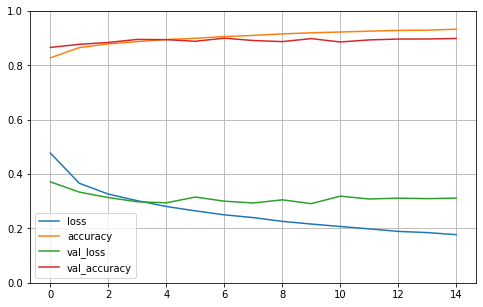

In [226]:
# Podemos plotar essas informações
pd.DataFrame(mlp.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [227]:
# Retorna o Loss e a Métrica (acurácia, neste caso).
# Aqui estamos testando o modelo utilizando o Conjunto de Teste
mlp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3367 - accuracy: 0.8910


[0.3366531431674957, 0.890999972820282]

## Predições
Como utilizamos a Função de Ativação **'SoftMax'** na Camada de Output, teremos uma **distribuição de probabilidades** das classes ao predizermos a classificação de novas instâncias.  

In [228]:
# Definindo 5 instâncias para teste
X_new = X_test[:5]
y_pred_proba = mlp.predict(X_new)
y_pred_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.91, 0.  , 0.  , 0.  ]],
      dtype=float32)

## Salvando/Carregando uma Rede Neural treinada
Desta forma, precisamos apenas carregar a rede, e não precisamos treiná-la toda vez que formos fazer uma predição. 

In [229]:
# Para salvar, basta utilizar a função save()
# No caso deste exemplo, nós já temos um modelo salvo pelo callback de CheckPoint que criamos ao treinarmos.
mlp.save('mlp_model.h5')

In [230]:
# Para Carregar, a função models.load_model()
modelo_carregado = keras.models.load_model('checkpoint_model.h5')

modelo_carregado.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3275 - accuracy: 0.8912


[0.32754096388816833, 0.8912000060081482]